Install and import dependencies

In [1]:
#import dependecies
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

Build data loading function

In [2]:
Capuchin_File = os.path.join('data','Parsed_Capuchinbird_Clips','XC3776-3.wav')
Not_Capuchin_File = os.path.join('data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

In [4]:
def load_wav_16k_mono(filename):
    #load contents of file
    file_contents = tf.io.read_file(filename)

    #decode file
    wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)

    #remove trailing axis
    wav = tf.squeeze(wav,axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    #Goes from 44100HZ to 16000HZ
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [5]:
#plot a wave

wav_capuchin = load_wav_16k_mono(Capuchin_File)
wav_not_capuchin = load_wav_16k_mono(Not_Capuchin_File)


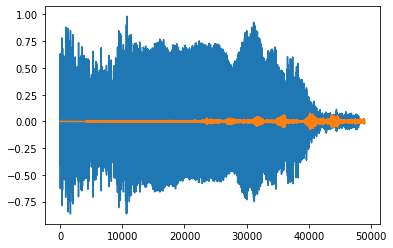

In [6]:
plt.plot(wav_capuchin)
plt.plot(wav_not_capuchin)
plt.show()

Create dataset

Define paths to data files

In [8]:
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

Create datasets

In [9]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

Add labels

In [14]:
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

Determine average length of bird call

Calculate wave cycle length

In [20]:
lengths = []
for file in os.listdir(POS):
    tensor_wav = load_wav_16k_mono(os.path.join(POS,file))
    lengths.append(len(tensor_wav))

In [21]:
lengths

[40000,
 48000,
 56000,
 48000,
 56000,
 64000,
 64000,
 64000,
 56000,
 56000,
 48000,
 56000,
 64000,
 56000,
 40000,
 64000,
 64000,
 64000,
 64000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 56000,
 56000,
 64000,
 64000,
 48000,
 56000,
 64000,
 56000,
 64000,
 32000,
 40000,
 48000,
 40000,
 56000,
 56000,
 56000,
 56000,
 48000,
 48000,
 64000,
 64000,
 48000,
 64000,
 48000,
 48000,
 40000,
 48000,
 48000,
 56000,
 56000,
 48000,
 40000,
 56000,
 48000,
 40000,
 56000,
 48000,
 48000,
 56000,
 48000,
 64000,
 64000,
 40000,
 40000,
 72000,
 56000,
 56000,
 56000,
 64000,
 56000,
 64000,
 64000,
 56000,
 56000,
 56000,
 48000,
 48000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 56000,
 48000,
 56000,
 40000,
 64000,
 56000,
 56000,
 40000,
 64000,
 56000,
 64000,
 48000,
 64000,
 56000,
 48000,
 48000,
 48000,
 64000,
 64000,
 64000,
 48000,
 48000,
 56000,
 48000,
 64000,
 48000,
 64000,
 56000,
 56000,
 56000,
 48000,
 56000,
 56000,
 40000,
 48000,
 48000,


summary stats

In [22]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [23]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [24]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

Preprocessing

build func

In [25]:
def preprocess(file_path,label):
    wav = load_wav_16k_mono(file_path)
    #shorten to around average length
    wav = wav[:48000]
    #pad out shorter calls
    zero_padding = tf.zeros([48000]-tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    
    #build spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram,axis=2)
    return spectrogram, label

test and visualise spectrogram

In [35]:
filepath,label = positives.shuffle(1000).as_numpy_iterator().next()



In [36]:
spectrogram,label = preprocess(filepath,label)

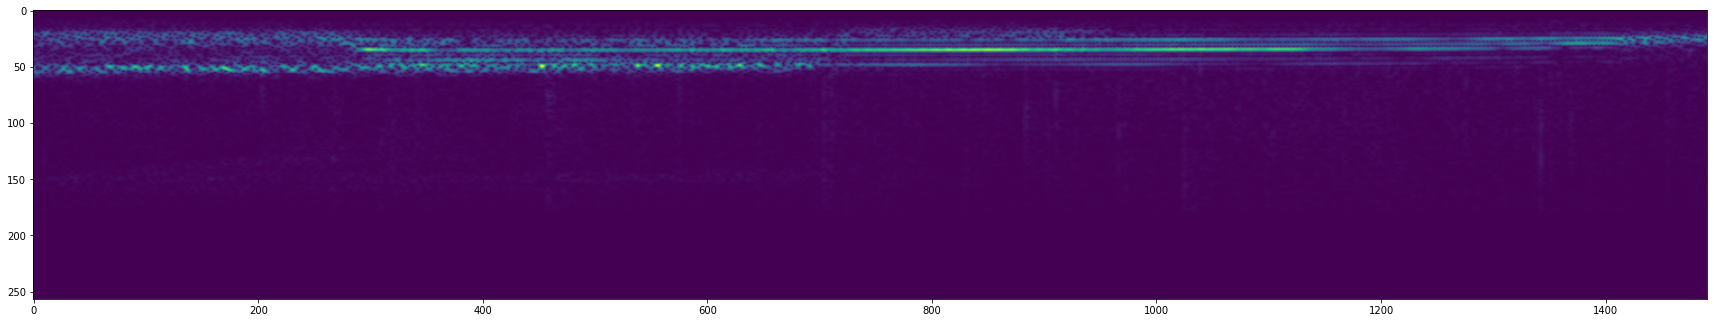

In [37]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

Create training and testing partitions

In [38]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(1000)
data = data.batch(16)
data = data.prefetch(8)

In [40]:
#split into test and train
train = data.take(36)
test = data.skip(36).take(15)

In [41]:
samples, labels = train.as_numpy_iterator().next()


In [43]:
samples.shape

(16, 1491, 257, 1)

Build the CNN

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [45]:
#building the model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491,257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [46]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________
